In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from time import time
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from nn_models import *

import pickle
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import colorlover as cl
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from utils import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
__date__ = '2017-08-04'
%matplotlib inline
HTML('''<script> code_show_err=false;  function code_toggle_err() {if (code_show_err){$('div.output_stderr').hide();} else {$('div.output_stderr').show();}code_show_err = !code_show_err} $( document ).ready(code_toggle_err);</script>To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

Using TensorFlow backend.


/home/asturkmani/Thesis-Old/utils.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(41178, 6, 1) (41178,) (41178, 6, 1) (41178,)
Dataset size: (18200, 15) 

Number of apps that consume 90.0 % of all users time:  15 



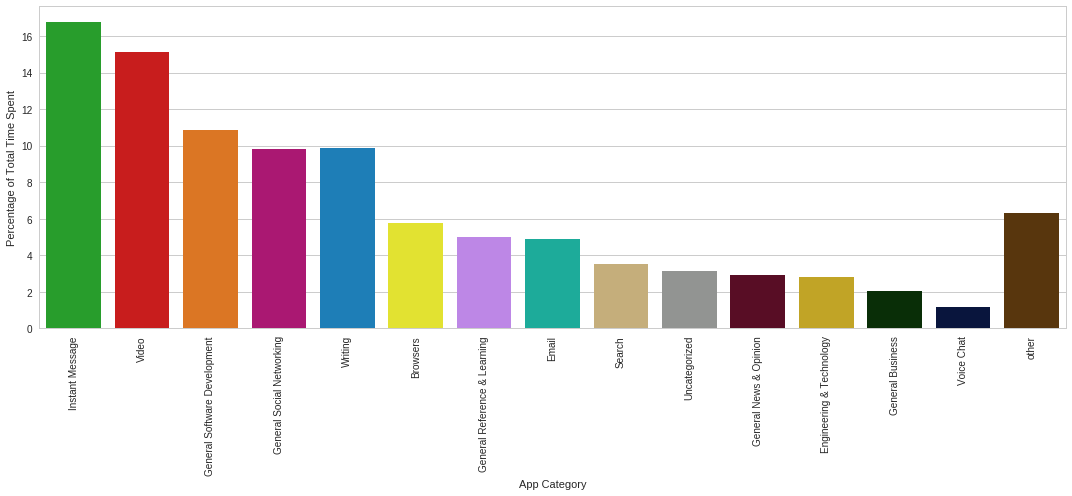

In [3]:
window_size = 6
batch_size = 100
data_ = make_clean_data(window_size, batch_size,multiplier=1)

time_percentage=0.9
time_spent = data_['dataset'].sum(axis=0)/data_['dataset'].sum()*100

print("Dataset size:", data_['yc'].shape,'\n')
print("Number of apps that consume", time_percentage*100, "% of all users time: ",len(data_['popular_apps']), '\n')

# app_colors = ['green','red', 'orange', 'magenta','cerulean', 'yellow', 'light purple', 'turquoise', 'tan', 'grey', 'maroon', 'gold', 'dark green', 'navy blue', 'brown']
# col_list_palette = sns.xkcd_palette(app_colors)
app_stats = pd.DataFrame.from_dict({'app' : data_['popular_apps'],'time_spent' : time_spent.tolist(),'colors' : data_['data_colors']})

sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
plt.xticks(rotation=90)
ax = sns.barplot(x='app', y='time_spent', data=app_stats, palette=data_['data_colors'])
plt.xlabel(s='App Category')
plt.ylabel(s='Percentage of Total Time Spent')
plt.tight_layout()
plt.savefig('TimeSpentDistribution.svg', format='svg', dpi=1200)

# PCA

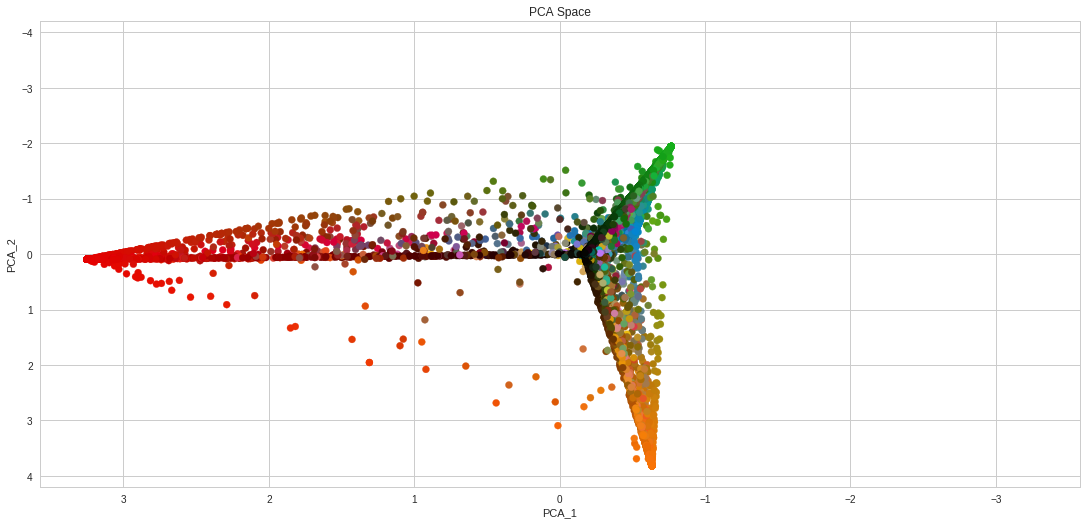

In [3]:
data_pca = PCA(n_components=2, whiten=True)
data_pca = data_pca.fit_transform(data_['yc'])
x = data_pca[:,0]
y = data_pca[:,1]
x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
yc_colz = [tuple(x) for x in data_['yc_colors'].tolist()]
fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=yc_colz)
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('PCA Space')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.savefig('PCA.svg', format='svg', dpi=1200)

# VAE

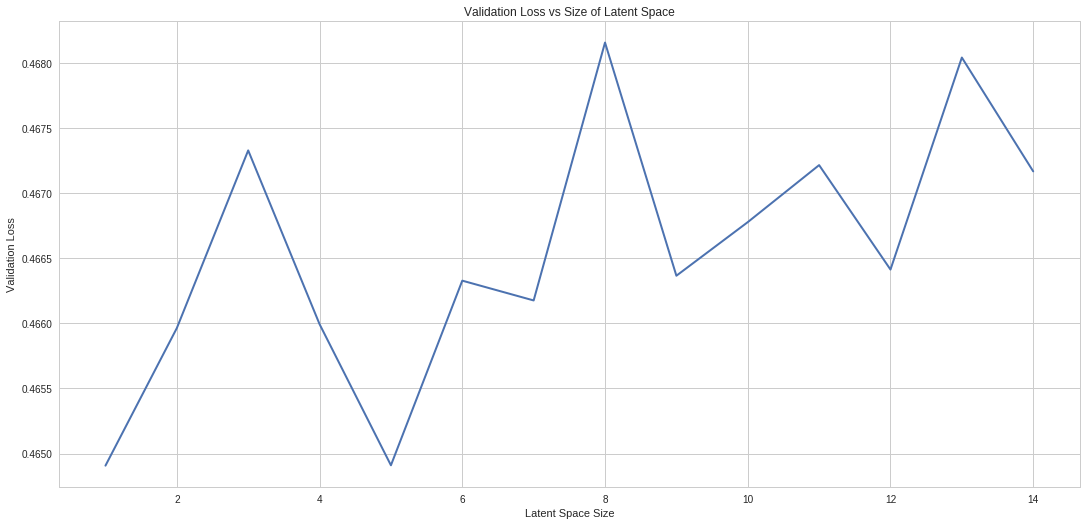

In [45]:
losses = list()
for n_z in range(1,15):
    vae, encoder, generator = build_vae(original_dim,batch_size = batch_size,latent_dim = n_z,intermediate_dim = 0,activ='elu',optim=RMSprop(),epsilon_std=1.)
    vae_hist = vae.fit(x=data_['y_train_c'], y=data_['y_train_c'],verbose = 0,batch_size=batch_size,epochs=epochs,validation_data = (data_['y_test_c'],data_['y_test_c']),callbacks = [EarlyStopping(patience = 5)])
    losses.append(min(vae_hist.history['val_loss']))
    
    
x = np.arange(len(losses))+1
fig = plt.figure(figsize=(15,7))
linewidth=2
linetype = '-'
plt.plot(x, losses, linetype, linewidth=linewidth)
# plt.autoscale()
plt.tight_layout()
plt.title('Validation Loss vs Size of Latent Space')
plt.xlabel('Latent Space Size')
plt.ylabel('Validation Loss')
plt.savefig('VAE_latent_size_loss.svg', format='svg', dpi=1200)

In [46]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 0
epochs = 100
batch_size = 100

vae, encoder, generator = build_vae(original_dim,
              batch_size = batch_size,
              latent_dim = latent_dim,
              intermediate_dim = 0,
              activ='elu',
              optim=RMSprop(),
              epsilon_std=1.)
# print(vae.summary())
# SVG(model_to_dot(vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

0.466133495586


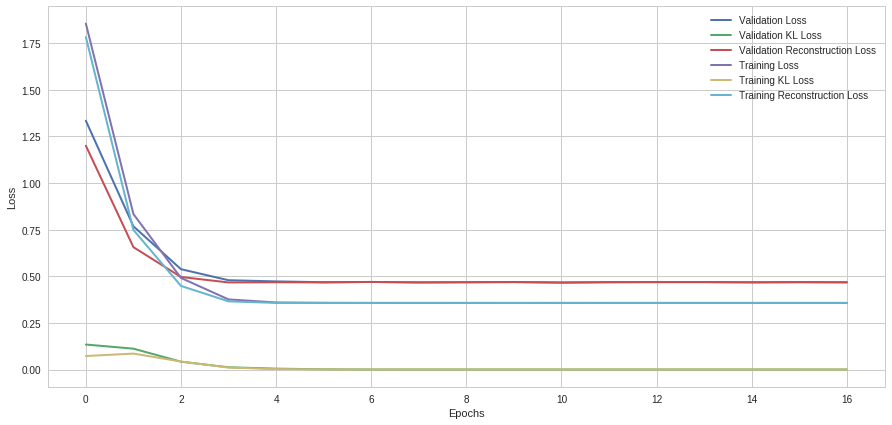

In [47]:
# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0)
vae_hist = vae.fit(x=data_['y_train_c'], 
                   y=data_['y_train_c'],
                   verbose = 0,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data = (
                       data_['y_test_c'],
                       data_['y_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 5)]
                  )
z_train = encoder.predict(data_['yc'])
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['yc'].shape[0], latent_dim)


print(min(vae_hist.history['val_loss']))
fig = plt.figure(figsize=(15,7))
x = np.arange(len(vae_hist.history['val_loss']))
linewidth=2
linetype = '-'
plt.plot(x, vae_hist.history['val_loss'], linetype, linewidth=linewidth, label='Validation Loss')
plt.plot(x, vae_hist.history['val_KL_loss'], linetype, linewidth=linewidth, label = 'Validation KL Loss')
plt.plot(x, vae_hist.history['val_recon_loss'], linetype, linewidth=linewidth, label='Validation Reconstruction Loss')
plt.plot(x, vae_hist.history['loss'], linetype, linewidth=linewidth, label='Training Loss')
plt.plot(x, vae_hist.history['KL_loss'], linetype, linewidth=linewidth, label='Training KL Loss')
plt.plot(x, vae_hist.history['recon_loss'], linetype, linewidth=linewidth, label='Training Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('VAE Losses.svg', format='svg', dpi=1200)

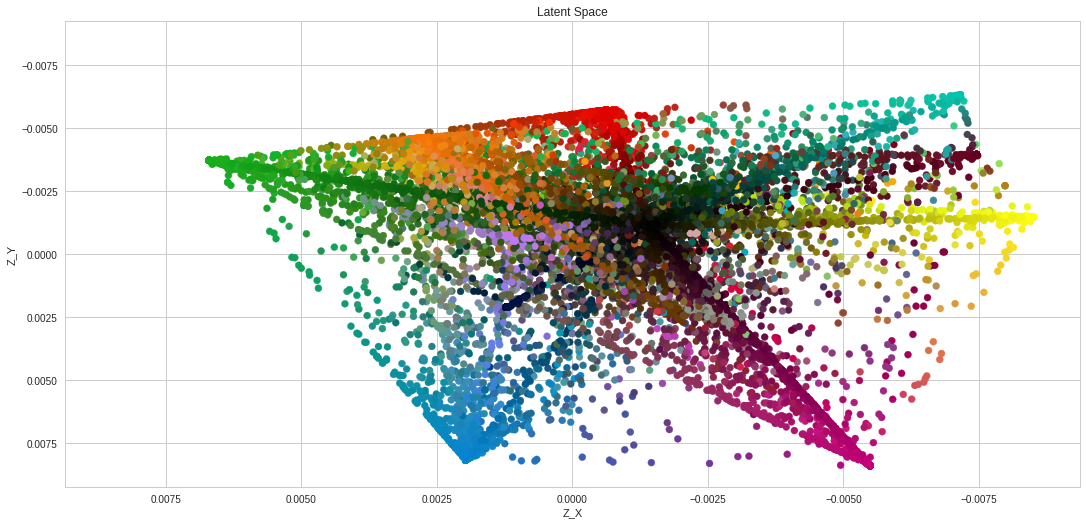

In [48]:
x = encodings[:,0]
y = encodings[:,1]
x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
yc_colz = [tuple(x) for x in data_['yc_colors'].tolist()]
fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=yc_colz)
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.savefig('VAE_Latent_Space.svg', format='svg', dpi=1200)

# Conditional VAE with Time & Day

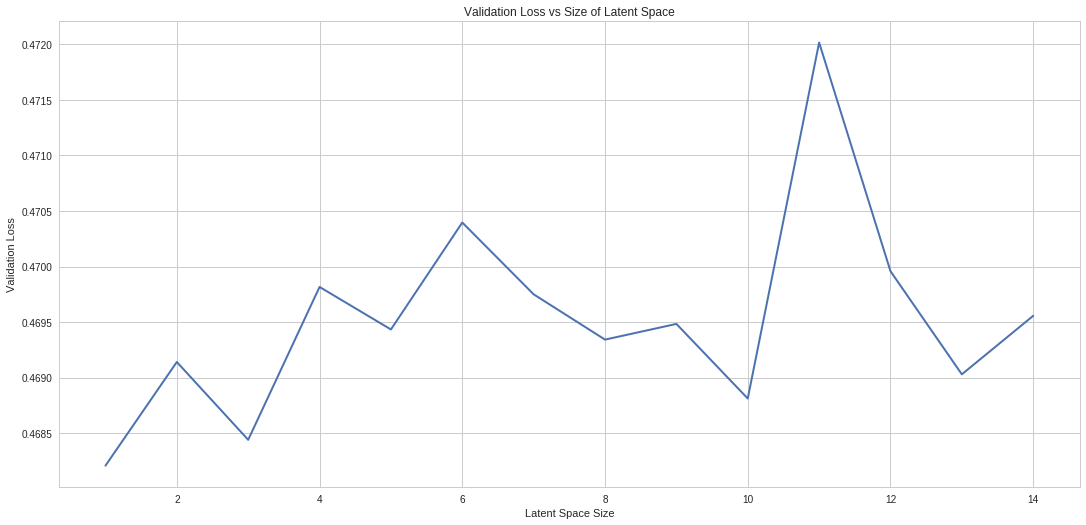

In [49]:
losses = list()
for n_z in range(1,15):
    c_vae, c_encoder, c_generator =  buid_cvae(original_dim,
              batch_size = batch_size,
              latent_dim = n_z,
              intermediate_dim = 0,
              activ='relu',
              optim=RMSprop(),
              epsilon_std=1.,
              time_dim=24,
              day_dim=7)
    c_vae_hist = c_vae.fit([data_['y_train_c'], to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t'])], 
                            data_['y_train_c'], 
                            verbose = 0, 
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data = (
                                [data_['y_test_c'], to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t'])], 
                                data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5)])
    losses.append(min(c_vae_hist.history['val_loss']))
    
    
x = np.arange(len(losses))+1
fig = plt.figure(figsize=(15,7))
linewidth=2
linetype = '-'
plt.plot(x, losses, linetype, linewidth=linewidth)
# plt.autoscale()
plt.tight_layout()
plt.title('Validation Loss vs Size of Latent Space')
plt.xlabel('Latent Space Size')
plt.ylabel('Validation Loss')
plt.savefig('c_VAE_latent_size_loss.svg', format='svg', dpi=1200)

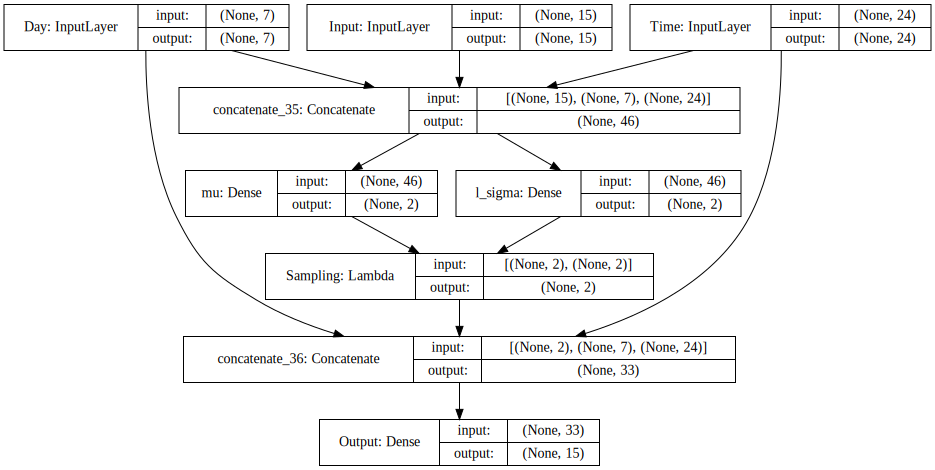

In [50]:
c_vae, c_encoder, c_generator =  buid_cvae(original_dim,
              batch_size = batch_size,
              latent_dim = 2,
              intermediate_dim = 0,
              activ='relu',
              optim=RMSprop(),
              epsilon_std=1.,
              time_dim=24,
              day_dim=7)
# print(c_vae.summary())
SVG(model_to_dot(c_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

0.46843894778


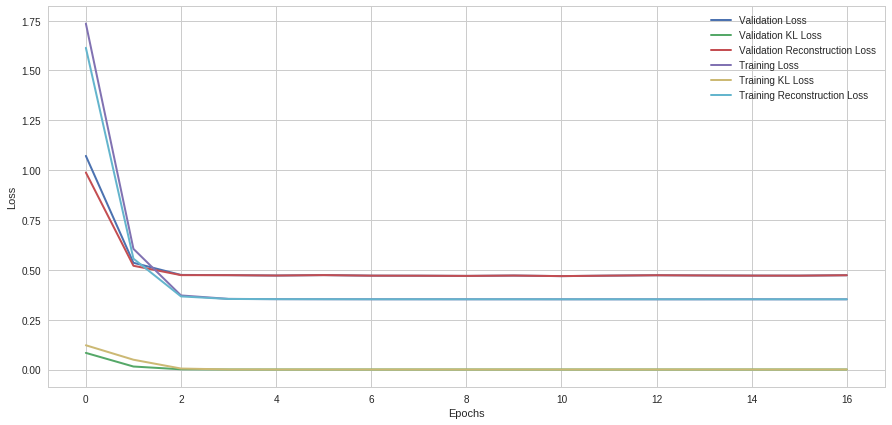

In [51]:
# compile and fit
c_vae_hist = c_vae.fit([data_['y_train_c'], to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t'])], 
                            data_['y_train_c'], 
                            verbose = 0, 
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data = (
                                [data_['y_test_c'], to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t'])], 
                                data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5)])


print(min(c_vae_hist.history['val_loss']))
fig = plt.figure(figsize=(15,7))
x = np.arange(len(c_vae_hist.history['val_loss']))
linewidth=2
linetype = '-'
plt.plot(x, c_vae_hist.history['val_loss'], linetype, linewidth=linewidth, label='Validation Loss')
plt.plot(x, c_vae_hist.history['val_KL_loss'], linetype, linewidth=linewidth, label = 'Validation KL Loss')
plt.plot(x, c_vae_hist.history['val_recon_loss'], linetype, linewidth=linewidth, label='Validation Reconstruction Loss')
plt.plot(x, c_vae_hist.history['loss'], linetype, linewidth=linewidth, label='Training Loss')
plt.plot(x, c_vae_hist.history['KL_loss'], linetype, linewidth=linewidth, label='Training KL Loss')
plt.plot(x, c_vae_hist.history['recon_loss'], linetype, linewidth=linewidth, label='Training Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('C_VAE Losses.svg', format='svg', dpi=1200)

(18200, 2)


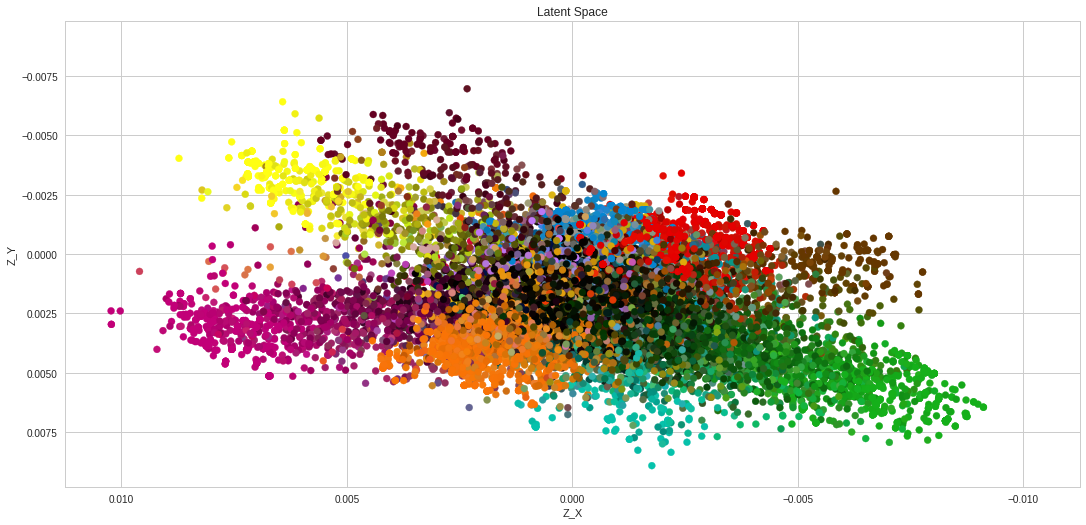

In [52]:
z_train = c_encoder.predict([data_['yc'], to_categorical(data_['yd']), to_categorical(data_['yt'])])
c_encoding = np.asarray(z_train)
print(c_encoding.shape)

x = c_encoding[:,0]
y = c_encoding[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
yc_colz = [tuple(x) for x in data_['yc_colors'].tolist()]
fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=yc_colz)
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.savefig('VAE_TD_Latent_Space.svg', format='svg', dpi=1200)

# LSTM VAE

/home/asturkmani/Thesis-Old/utils.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(41183, 1, 1) (41183,) (41183, 1, 1) (41183,)
1
(41182, 2, 1) (41182,) (41182, 2, 1) (41182,)
2
(41181, 3, 1) (41181,) (41181, 3, 1) (41181,)
3
(41180, 4, 1) (41180,) (41180, 4, 1) (41180,)
4
(41179, 5, 1) (41179,) (41179, 5, 1) (41179,)
5
(41178, 6, 1) (41178,) (41178, 6, 1) (41178,)
6
(41177, 7, 1) (41177,) (41177, 7, 1) (41177,)
7
(41176, 8, 1) (41176,) (41176, 8, 1) (41176,)
8
(41175, 9, 1) (41175,) (41175, 9, 1) (41175,)
9


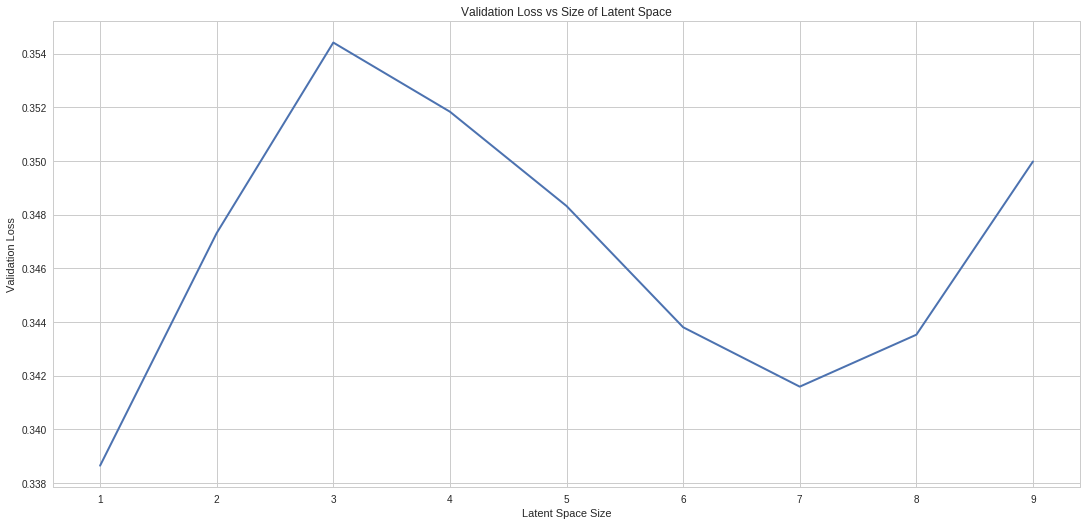

In [15]:
losses = list()
original_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
# time_dim = data_['time']
# day_dim = data_['days']

batch_size = 100
latent_dim = 2
lstm_dim = 32
intermediate_dim = 0

for timesteps in range(1,10):
    data_ = make_clean_data(timesteps, batch_size,multiplier=1)
    print(timesteps)
    lstm_vae, lstm_encoder, lstm_generator= build_lstm_c_vae(original_dim=original_dim,
                                       timesteps=timesteps,
                                       batch_size=batch_size,
                                       latent_dim=2,
                                       lstm_dim=lstm_dim,
                                       intermediate_dim=0,
                                       activ='relu',
                                       optim=RMSprop(),
                                       epsilon_std=1.,
                                       time_dim=0,
                                       day_dim=0)

    lstm_vae_hist = lstm_vae.fit(data_['x_train_c'], 
                   data_['x_train_c'],
                   verbose = 0,
                   batch_size=batch_size,
                   epochs=20,
                   validation_data = (
                       data_['x_test_c'],
                       data_['x_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 3, min_delta=0.0001),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=1, min_lr=0.000001, verbose=0)]
                  )
    losses.append(min(lstm_vae_hist.history['val_loss']))
    
    
x = np.arange(len(losses))+1
fig = plt.figure(figsize=(15,7))
linewidth=2
linetype = '-'
plt.plot(x, losses, linetype, linewidth=linewidth)
# plt.autoscale()
plt.tight_layout()
plt.title('Validation Loss vs Size of Latent Space')
plt.xlabel('Latent Space Size')
plt.ylabel('Validation Loss')
plt.savefig('LSTM_VAE_window_loss.svg', format='svg', dpi=1200)

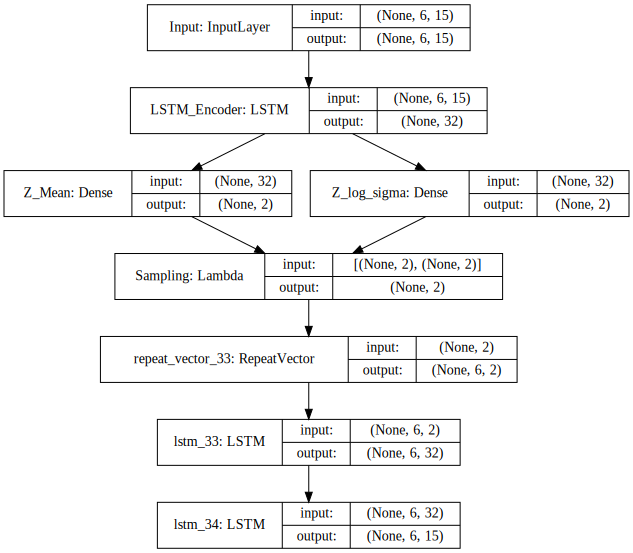

In [10]:
original_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
# time_dim = data_['time']
# day_dim = data_['days']

batch_size = 100
latent_dim = 2
lstm_dim = 32
intermediate_dim = 0
        
lstm_vae, lstm_encoder, lstm_generator= build_lstm_c_vae(original_dim,
                                       timesteps,
                                       batch_size,
                                       latent_dim,
                                       lstm_dim,
                                       intermediate_dim,
                                       activ='relu',
                                       optim=RMSprop(),
                                       epsilon_std=1.,
                                       time_dim=0,
                                       day_dim=0)

# print(lstm_vae.summary())
SVG(model_to_dot(lstm_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

0.35607913716


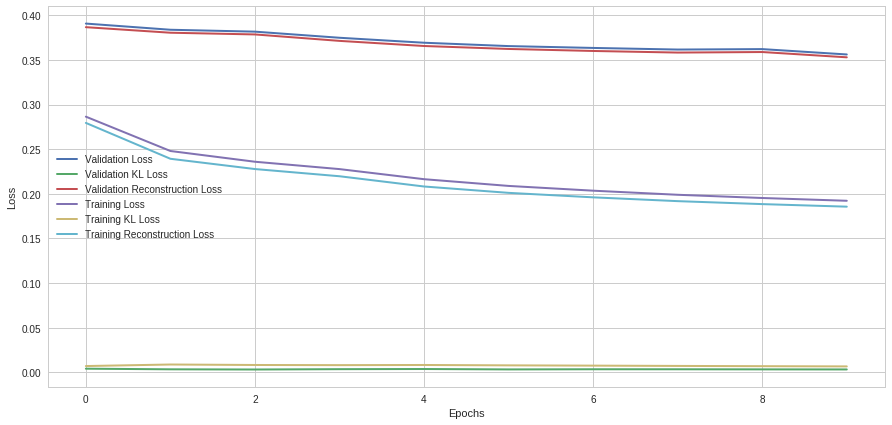

In [11]:
lstm_vae_hist = lstm_vae.fit(data_['x_train_c'], 
                   data_['x_train_c'],
                   verbose = 0,
                   batch_size=batch_size,
                   epochs=10,
                   validation_data = (
                       data_['x_test_c'],
                       data_['x_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 5, min_delta=0.0001),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.000001, verbose=0)]
                  )

print(min(lstm_vae_hist.history['val_loss']))
fig = plt.figure(figsize=(15,7))
x = np.arange(len(lstm_vae_hist.history['val_loss']))
linewidth=2
linetype = '-'
plt.plot(x, lstm_vae_hist.history['val_loss'], linetype, linewidth=linewidth, label='Validation Loss')
plt.plot(x, lstm_vae_hist.history['val_KL_loss'], linetype, linewidth=linewidth, label = 'Validation KL Loss')
plt.plot(x, lstm_vae_hist.history['val_recon_loss'], linetype, linewidth=linewidth, label='Validation Reconstruction Loss')
plt.plot(x, lstm_vae_hist.history['loss'], linetype, linewidth=linewidth, label='Training Loss')
plt.plot(x, lstm_vae_hist.history['KL_loss'], linetype, linewidth=linewidth, label='Training KL Loss')
plt.plot(x, lstm_vae_hist.history['recon_loss'], linetype, linewidth=linewidth, label='Training Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LSTM_VAE Losses.svg', format='svg', dpi=1200)

# Show color of average activity over time period

(18200, 2)


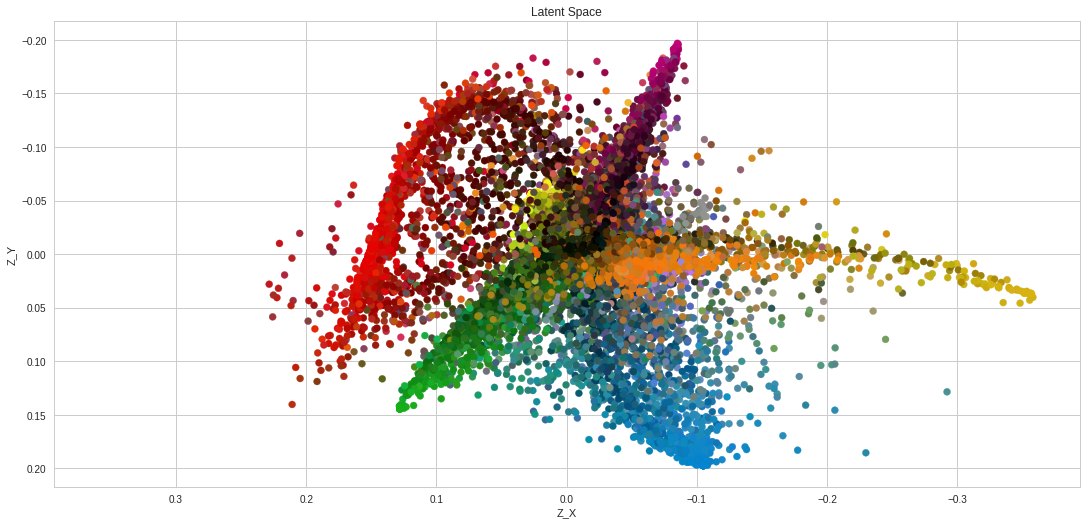

In [13]:
z_train = lstm_encoder.predict(data_['Xc'])
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['Xc'].shape[0], latent_dim)
xavg = data_['Xc'].mean(axis=1)
avg_colors = np.einsum('ij,jk->ik', xavg, data_['data_colors'])
avg_colors = [tuple(x) for x in avg_colors.tolist()]
print(encodings.shape)

x = encodings[:,0]
y = encodings[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1

fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=avg_colors)
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.savefig('Seq2Seq_VAE_Latent_Space.svg', format='svg', dpi=1200)

# LSTM VAE with Time & Day

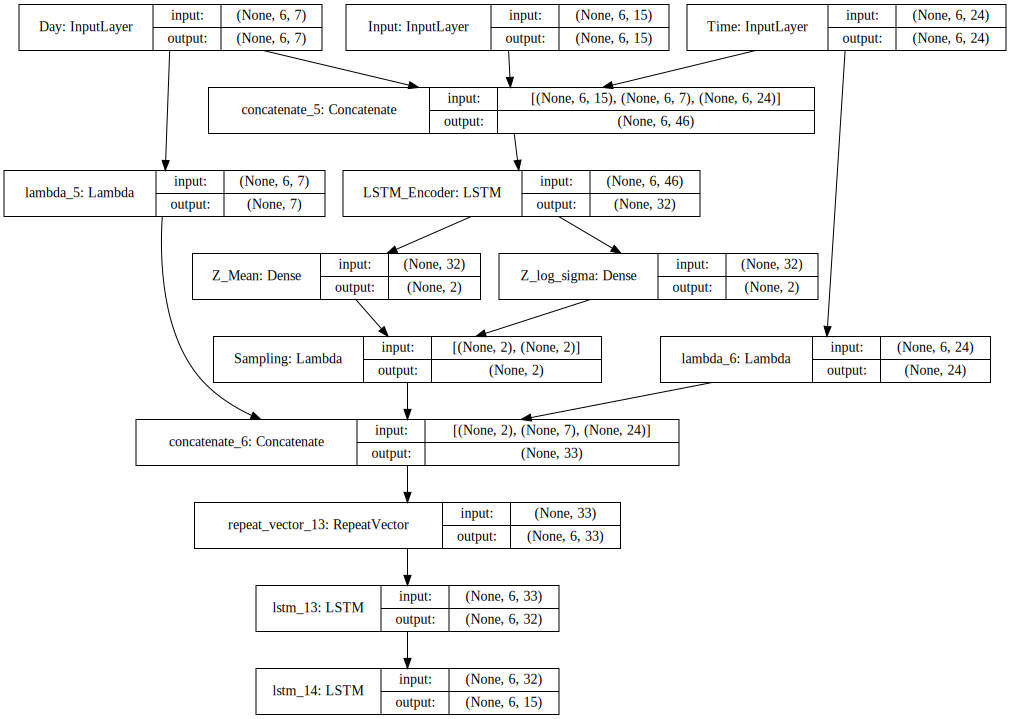

In [32]:
original_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
# time_dim = data_['time']
# day_dim = data_['days']

batch_size = 50
latent_dim = 2
lstm_dim = 32
intermediate_dim = 0
        
clstm_vae, clstm_encoder, clstm_generator= build_lstm_c_vae(original_dim,
                                       timesteps,
                                       batch_size,
                                       latent_dim,
                                       lstm_dim,
                                       intermediate_dim,
                                       activ='relu',
                                       optim=Adam(lr=0.005),
                                       epsilon_std=1.,
                                       time_dim=24,
                                       day_dim=7)

# print(lstm_vae.summary())
SVG(model_to_dot(clstm_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [33]:
x_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['Xd']])
x_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['Xt']])

x_train_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_train_d']])
x_train_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_train_t']])

x_test_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_test_d']])
x_test_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_test_t']])

# compile and fit
clstm_vae_hist = clstm_vae.fit(
    [data_['x_train_c'], x_train_d, x_train_t], 
    data_['x_train_c'], 
    verbose = 0, 
    batch_size=batch_size, 
    epochs=100,
    validation_data = ([data_['x_test_c'], x_test_d,x_test_t], 
                        data_['x_test_c']),
    callbacks = [EarlyStopping(patience = 5, min_delta=0.0001),ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.000001, verbose=0)])

(18200, 2)


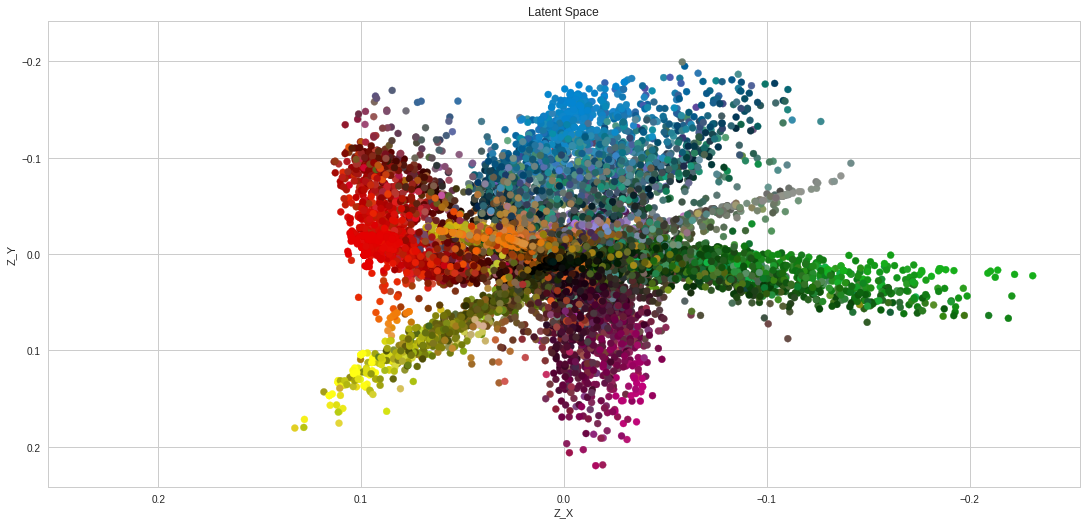

In [35]:
z_train = clstm_encoder.predict([data_['Xc'], x_d, x_t])
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['Xc'].shape[0], latent_dim)
xavg = data_['Xc'].mean(axis=1)
avg_colors = np.einsum('ij,jk->ik', xavg, data_['data_colors'])
avg_colors = [tuple(x) for x in avg_colors.tolist()]
print(encodings.shape)

x = encodings[:,0]
y = encodings[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1

fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=avg_colors)
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.savefig('Seq2Seq_CVAE_Latent_Space.svg', format='svg', dpi=1200)

# Conv1D / LSTM for Time Series Prediction

Here we examine first using a conv1d/lstm to make time-series regression on the next 5-minute block and visualize hidden states in the latent space

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 6, 15)             0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 4, 64)             2944      
_________________________________________________________________
Flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
Dense_Out2 (Dense)           (None, 15)                3855      
Total params: 6,799
Trainable params: 6,799
Non-trainable params: 0
_________________________________________________________________
None


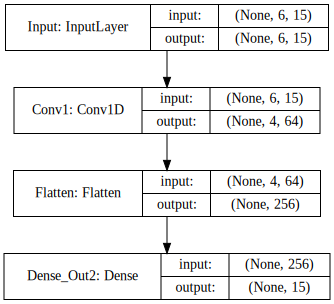

In [26]:
window_size=6
filter_length=3
original_dim = data_['x_train_c'].shape[-1]
nb_input_series=original_dim
nb_outputs=original_dim
nb_filter=64

inputs = Input(shape=(window_size, original_dim), name='Input')
conv1 = Conv1D(name='Conv1', 
               filters=nb_filter, 
               kernel_size=filter_length, 
               activation='elu', 
               input_shape=(window_size, nb_input_series)
              )(inputs)

flat1 = Flatten(name='Flatten')(conv1)
output = Dense(nb_outputs, activation='elu',name='Dense_Out2')(flat1)     # For binary classification, change the activation to 'sigmoid'
 
conv_encoder = Model(inputs,flat1)
conv_model = Model(inputs,output)
conv_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
print(conv_model.summary())
# To perform (binary) classification instead:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
SVG(model_to_dot(conv_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

[ 1  2  3  4  5  6  7  8  9 10 11]
[0.013235635985102918, 0.013130196084578832, 0.012767016531692611, 0.012864052595363723, 0.012792618961797821, 0.01273251769443353, 0.012808357949058215, 0.013056221053832107, 0.013059808715350098, 0.013107034501930077, 0.013048249272008736]


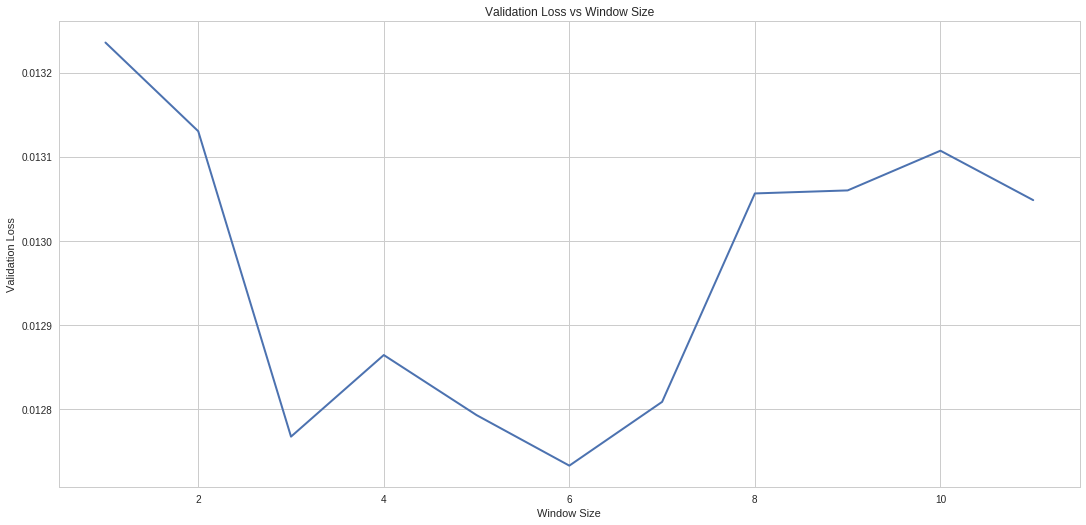

In [36]:
losses= list()
for window_size in range(1,12):
    filter_length=3
    if filter_length > window_size:
        filter_length = window_size
    timesteps = window_size
    data_ = make_clean_data(window_size, batch_size,multiplier=1)
    print(timesteps)

    inputs = Input(shape=(window_size, original_dim), name='Input')
    conv1 = Conv1D(name='Conv1', 
                   filters=nb_filter, 
                   kernel_size=filter_length, 
                   activation='elu', 
                   input_shape=(window_size, nb_input_series)
                  )(inputs)

    flat1 = Flatten(name='Flatten')(conv1)
    output = Dense(nb_outputs, activation='elu',name='Dense_Out2')(flat1)     # For binary classification, change the activation to 'sigmoid'

    conv_encoder = Model(inputs,flat1)
    conv_model = Model(inputs,output)
    conv_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
    conv_model_data = conv_model.fit(
        data_['x_train_c'], 
        data_['y_train_c'], 
        verbose=2, 
        epochs=1000, 
        batch_size=128, 
        validation_data=(data_['x_test_c'], data_['y_test_c']), 
        callbacks=[reduce_lr,early_stop])
    losses.append(min(conv_model_data.history['val_loss']))

x = np.arange(len(losses))+1
fig = plt.figure(figsize=(15,7))
linewidth=2
linetype = '-'
plt.plot(x, losses, linetype, linewidth=linewidth)
# plt.autoscale()
plt.tight_layout()
plt.title('Validation Loss vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Validation Loss')
plt.savefig('Conv1D_window_loss.svg', format='svg', dpi=1200)

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
conv_model_data = conv_model.fit(
    data_['x_train_c'], 
    data_['y_train_c'], 
    verbose=2, 
    epochs=1000, 
    batch_size=128, 
    validation_data=(data_['x_test_c'], data_['y_test_c']), 
    callbacks=[reduce_lr,early_stop])

Train on 14600 samples, validate on 3600 samples
Epoch 1/1000
5s - loss: 0.0180 - mean_absolute_error: 0.0669 - val_loss: 0.0157 - val_mean_absolute_error: 0.0624
Epoch 2/1000
0s - loss: 0.0129 - mean_absolute_error: 0.0486 - val_loss: 0.0141 - val_mean_absolute_error: 0.0558
Epoch 3/1000
0s - loss: 0.0123 - mean_absolute_error: 0.0452 - val_loss: 0.0135 - val_mean_absolute_error: 0.0513
Epoch 4/1000
0s - loss: 0.0122 - mean_absolute_error: 0.0440 - val_loss: 0.0132 - val_mean_absolute_error: 0.0509
Epoch 5/1000
0s - loss: 0.0121 - mean_absolute_error: 0.0437 - val_loss: 0.0136 - val_mean_absolute_error: 0.0517
Epoch 6/1000
0s - loss: 0.0121 - mean_absolute_error: 0.0437 - val_loss: 0.0131 - val_mean_absolute_error: 0.0509
Epoch 7/1000
0s - loss: 0.0121 - mean_absolute_error: 0.0434 - val_loss: 0.0131 - val_mean_absolute_error: 0.0502
Epoch 8/1000
0s - loss: 0.0121 - mean_absolute_error: 0.0434 - val_loss: 0.0128 - val_mean_absolute_error: 0.0492
Epoch 9/1000
0s - loss: 0.0121 - mean_a

In [ ]:
y_pred = conv_model.predict(data_['x_test_c'], batch_size=20)
Y_test = data_['y_test_c']
for i in range(0,Y_test.shape[0],10):
    print("=== Prediction ===", "\n")
    print(np.round(y_pred[i]*300), "\n")
    print("=== True value ===","\n")
    print(np.round(Y_test[i]*300), "\n")

# Comparing latent space of Prediction vs True Value

In [ ]:
y_pred_z = vae.predict(y_pred, batch_size=20)
y_true_z = vae.predict(Y_test, batch_size=20)
print(y_pred_z.shape, y_true_z.shape)

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

In [ ]:
y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = y_pred_z[:,0]
y = y_pred_z[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = y_pred_colors, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

In [ ]:
x = y_true_z[:,0]
y = y_true_z[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['y_test_c_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

In [ ]:
x_train_encoded_conv = conv_encoder.predict(data_['x_train_c'])
x_test_encoded_conv = conv_encoder.predict(data_['x_test_c'])
print(x_train_encoded_conv.shape)
print(x_test_encoded_conv.shape)
x_encoded = np.concatenate((x_train_encoded_conv,x_test_encoded_conv),axis=0)
print(x_encoded.shape)

## VAE on Conv1D hidden state

In [ ]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 10
epochs = 100
batch_size = 20

conv_vae, conv_vae_encoder, conv_vae_generator = buid_cvae(x_encoded.shape[1],
              batch_size = 20,
              latent_dim = 2,
              intermediate_dim = 64,
              intermediate_dim2 = 32,
              activ='relu',
              optim=Adam(lr=0.0005),
              epsilon_std=1.)
print(conv_vae.summary())
SVG(model_to_dot(conv_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

conv_vae.fit(x_train_encoded_conv,
             x_train_encoded_conv,
            shuffle=True,
            epochs=epochs,
             verbose=0,
            batch_size=batch_size,
            validation_data=(x_test_encoded_conv,x_test_encoded_conv),
           callbacks=[early_stop,TQDMNotebookCallback(metric_format="{name}: {value:0.4f}")])

In [ ]:
# display a 2D plot of the digit classes in the latent space
conv_vae_encoded = conv_vae_encoder.predict(x_encoded, batch_size=batch_size)


x = conv_vae_encoded[:,0]
y = conv_vae_encoded[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Conv-Data')

# Analysis
Here it is important to remember that the encoded representation is the summary of the previous window of activity and the label is the next time step
    1. Clusters of the same color therefore signify apps that tend to be used consistently and focused on for extended periods of time
    2. There seem to be 6 gaussians in this latent space signifying this latent distribution is in fact a mixture of Gaussians. Since this latent space is a generative one, we can infer that there exist 6 main modes of app-usage behaviour. Below we visualize the Gaussian Mixtures

In [ ]:
nk=6
kmeans = KMeans(n_clusters=nk).fit(conv_vae_encoded)
gmm_scaled = GaussianMixture(n_components = nk, covariance_type='tied')
gmm_scaled.fit(conv_vae_encoded)
gmm_scaled_labels = gmm_scaled.predict(conv_vae_encoded)

In [ ]:
x = conv_vae_encoded[:,0]
y = conv_vae_encoded[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]
bupu = cl.scales[str(nk)]['div']['RdBu']
c = [bupu[x] for x in kmeans.labels_]
trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = c, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Conv-Data-GMM')

### Time & Day VAE on Conv1D hidden state

In [ ]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 10
epochs = 100
batch_size = 20

conv_vae_td, conv_vae_encoder_td, conv_vae_generator_td = buid_cvae(
    x_encoded.shape[1],
    batch_size = 20,
    latent_dim = 2,
    intermediate_dim = 64,
    intermediate_dim2 = 32,
    activ='relu',
    optim=Adam(lr=0.0005),
    epsilon_std=1.,
    time_dim=time_dim,
    day_dim=days_dim)

In [ ]:
# compile and fit
conv_vae_td_hist = conv_vae_td.fit([x_train_encoded_conv, to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t'])], 
                            x_train_encoded_conv, 
                            verbose = 0, 
                            shuffle=False,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data = (
                                [x_test_encoded_conv, to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t'])], 
                                x_test_encoded_conv),
                            callbacks = [EarlyStopping(patience = 5),
                                         TQDMNotebookCallback(metric_format="{name}: {value:0.4f}")])


In [ ]:
# display a 2D plot of the digit classes in the latent space
conv_vae_encoded_td = conv_vae_encoder_td.predict([x_encoded, to_categorical(data_['yd']), to_categorical(data_['yt'])], batch_size=batch_size)


x = conv_vae_encoded_td[:,0]
y = conv_vae_encoded_td[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Conv-Data')

# LSTM, VAE, VAE_TD

In [ ]:
inputs = Input(shape=(window_size, original_dim), name='Inputs')
# inputs_masked = Masking(mask_value=0., name='Masking')(inputs)
encoded = LSTM(64, name='LSTM', activation='elu')(inputs)
output = Dense(original_dim, activation='linear')(encoded)

rnn_encoder = Model(inputs, encoded)
rnn_model = Model(inputs, output)

rnn_model.compile(loss='mse', metrics=['mae'], optimizer='rmsprop')
print(rnn_model.summary())

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
rnn_model_hist= rnn_model.fit(
    data_['x_train_c'], 
    data_['y_train_c'], 
    verbose=0, 
    epochs=1000, 
    batch_size=128, 
    validation_data=(data_['x_test_c'], data_['y_test_c']), 
    callbacks=[reduce_lr,
               early_stop,
               TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",leave_outer=True,leave_inner=True)])

In [ ]:
y_pred = rnn_model.predict(data_['x_test_c'], batch_size=20)
Y_test = data_['y_test_c']
for i in range(0,Y_test.shape[0],10):
    print("=== Prediction ===", "\n")
    print(np.round(y_pred[i]*300), "\n")
    print("=== True value ===","\n")
    print(np.round(Y_test[i]*300), "\n")

In [ ]:
y_pred_z = vae.predict(y_pred, batch_size=20)
y_true_z = vae.predict(Y_test, batch_size=20)
print(y_pred_z.shape, y_true_z.shape)

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = y_pred_z[:,0]
y = y_pred_z[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = y_pred_colors, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

In [ ]:
# y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = y_true_z[:,0]
y = y_true_z[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['y_test_c_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

# End-To-End LSTM/Conv1D + VAE

In [ ]:
hidden = 64
uncertainty = 2
batch_size = 20

inputs = Input(shape=(window_size, original_dim), name='Inputs')

# inputs_masked = Masking(mask_value=0., name='Masking')(inputs)
encoded = LSTM(hidden, name='LSTM', activation='elu')(inputs)
lstm_output = Dense(original_dim, name='Dense', activation='linear')(encoded)

def sample_z(args):
        mu, l_sigma = args
        eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
        return mu + K.exp(l_sigma / 2) * eps
    
def z_upper(args):
    mu, l_sigma = args
    return mu + uncertainty*K.exp(l_sigma)

def z_lower(args):
    mu, l_sigma = args
    return mu - uncertainty*K.exp(l_sigma)

m = batch_size # batch size
n_z = latent_dim # latent space size
encoder_dim1 = intermediate_dim # dim of encoder hidden layer
decoder_dim = intermediate_dim # dim of decoder hidden layer
decoder_out_dim = original_dim # dim of decoder output layer
n_x = original_dim

# Encoder
encoder_h = Dense(encoder_dim1, activation='relu',  name='Encoder_H')(lstm_output)
mu = Dense(n_z, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(n_z, activation='linear', name='l_sigma')(encoder_h)

# Sampling
z = Lambda(sample_z, output_shape = (n_z, ), name='Sampling')([mu, l_sigma])
z_up = Lambda(z_upper, output_shape = (n_z, ), name='Z_Upper')([mu, l_sigma])
z_low = Lambda(z_lower, output_shape = (n_z, ), name='Z_Lower')([mu, l_sigma])

# Decoding Mean +/- 1 STD
decoder_hidden = Dense(decoder_dim, activation='relu', name='Decoder_H')
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name='Output')

h_p = decoder_hidden(z)
output = decoder_out(h_p)

output_up = decoder_out(decoder_hidden(z_up))
output_low = decoder_out(decoder_hidden(z_low))

def rnn_vae_loss(y_true, y_pred):
        recon = objectives.binary_crossentropy(output, lstm_output)
        pred = objectives.binary_crossentropy(y_pred, y_true)
        kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
        return recon + kl + pred

def pred_loss(y_true, y_pred):
    return objectives.binary_crossentropy(y_pred, y_true)

def vae_loss(y_true, y_pred):
    recon = objectives.binary_crossentropy(output, lstm_output)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

rnn_encoder = Model(inputs, lstm_output)
rnnvae_encoder = Model(inputs, mu)

rnnvae_model = Model(inputs, output)
rnnvae_model_upper = Model(inputs, output_up)
rnnvae_model_lower = Model(inputs, output_low)

rnnvae_model.compile(loss=rnn_vae_loss, metrics=[vae_loss, pred_loss], optimizer=Adam(lr=0.005))
print(rnnvae_model.summary())
SVG(model_to_dot(rnnvae_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [ ]:
rnnvae_model_hist= rnnvae_model.fit(
    data_['x_train_c'], 
    data_['y_train_c'], 
    verbose=0, 
    epochs=1000, 
    batch_size=batch_size, 
    validation_data=(data_['x_test_c'], data_['y_test_c']), 
    callbacks=[EarlyStopping(patience=5),
               TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",leave_outer=True,leave_inner=True)])

In [ ]:
rnn_z_encoded = rnnvae_encoder.predict(data_['x_test_c'], batch_size=20)
y_pred = rnnvae_model.predict(data_['x_test_c'], batch_size=20)
rnn_vae_encoded = vae.predict(y_pred, batch_size=20)
y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
# check if distance from z_upper to z_mean  > z_true to z_mean
print(rnn_z_encoded.shape)
print(y_pred.shape)

In [ ]:
# y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = rnn_vae_encoded[:,0]
y = rnn_vae_encoded[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = y_pred_colors, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

In [ ]:
# y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = rnn_z_encoded[:,0]
y = rnn_z_encoded[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = y_pred_colors, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

# Pre-Train LSTM VAE, MLP VAE, then End-To-End LSTM-VAE

# Convert all data to Z using VAE, Train LSTM, Decode

### Compare all above on prediction-in-std-range metric while training on MSE loss

In [ ]:
1 - show loss for latent=2/3/4/5 (show VAE loss)
2 - show graph of prediction vs timesteps
3 - Justify why VAE is normal
4 - concrete number on how predictable I am
5 - show accuracy vs data size